# FINAL PROJECT

Analysis provided by
- Clemente Recine
- Lorenzo Garcia Condoluci
- Filippo Mastrogiacomo
- Niccolo Mascaro
- Alessio Sentinelli

## Abstract 
We have undertaken a kaggle competition for our final project taken from the following link:

https://www.kaggle.com/c/restaurant-revenue-prediction


In particular the presented challenge consists of a database with many information about restaurants. The objective was to predict their revenue based on some 37 obfuscated variables.

First off we managed to explore the dataset with regard to the restaurant characteristics (City, type of city, type of restaurant and so on). Data exploration was done in two steps: first we analyzed the train set, in order to include the revenue in some studies. Then we moved to the test set to further explore the set of turkish restaurants we had to handle. To be able to predict the revenue we had to fit a linear model.


We implemented 3 different approaches:
1. We included all the 37 variables in the model, resulting in a 37-coefficient long regression equation.
2. We reduced the variables to 5 using a Principal Component Analysis and then applied the regression model to these 5 new variables.
3. We applied the "forward approach" to the linear model.

After having evaluated the results in terms of $R^2$ we proceed with the prediction. In the end we compared the results with a selected benchmark.

## Importing the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.linear_model   import LinearRegression
from sklearn.preprocessing  import StandardScaler
from sklearn.metrics        import mean_squared_error, r2_score
from sklearn.decomposition  import PCA

## Importing the dataset

In [ ]:
train_set = pd.read_csv('../dataset/train.csv', header='infer', parse_dates=['Open Date'], date_parser = pd.to_datetime)
test_set = pd.read_csv('../dataset/test.csv', header='infer', parse_dates=['Open Date'], date_parser = pd.to_datetime)

## Data exploration

In [ ]:
# Calculating the date from open day and scaling it.
launch_date = datetime.datetime(2015, 6, 6)
test_set['Open days'] = (launch_date - test_set['Open Date']).dt.days / 1000
train_set['Open days'] = (launch_date - train_set['Open Date']).dt.days / 1000

In [ ]:
test_set.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,Open days
0,0,2011-01-22,Niğde,Other,FC,1,4.0,4.0,4.0,1,2,5,4,5,5,5,3,4.0,0,0,0,2,0,5,5,3,1,4,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0,1.596
1,1,2011-03-18,Konya,Other,IL,3,4.0,4.0,4.0,2,2,5,3,4,4,2,4,5.0,0,0,0,0,0,5,5,3,2,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,1.541
2,2,2013-10-30,Ankara,Big Cities,FC,3,4.0,4.0,4.0,2,2,5,4,4,5,4,5,5.0,0,0,0,0,0,5,5,5,5,5,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0,0.584
3,3,2013-05-06,Kocaeli,Other,IL,2,4.0,4.0,4.0,2,3,5,4,5,4,3,4,5.0,0,0,0,0,4,4,4,3,2,2,0,0,0.0,0.0,2.0,3.0,0,4,0,0,0,0,0,0,0.761
4,4,2013-07-31,Afyonkarahisar,Other,FC,2,4.0,4.0,4.0,1,2,5,4,5,4,3,5,4.0,0,0,0,0,0,1,5,3,1,1,0,0,0.0,0.0,5.0,3.0,0,0,0,0,0,0,0,0,0.675


In [ ]:
# The shape of the dataframes we are considering. The size difference between the two is quite great.

train_set.shape , test_set.shape

((137, 44), (100000, 43))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0, 0.5, 'P(revenue)'), Text(0.5, 0, 'revenue')]

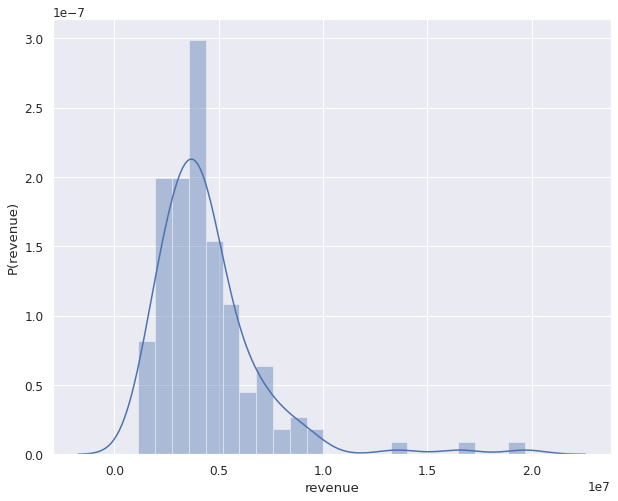

In [ ]:
# First of all let us see how the target column "revenue" is distributed

sns.set(palette="deep", font_scale=1.1, rc={"figure.figsize": [10, 8]})
sns.distplot(
    train_set['revenue'], norm_hist=False, kde=True
).set(xlabel='revenue', ylabel='P(revenue)')

Given this right-skewed distribution, we can clearly see the presence of three different outliers.

In [ ]:
train_set[train_set['revenue'] > 10000000 ]

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue,Open days
16,16,2000-01-07,İstanbul,Big Cities,FC,3,5.0,4.0,4.0,2,5,5,4,5,4,3,5,4.0,0,0,0,0,0,1,4,1,1,1,0,0,0.0,0.0,2.0,2.0,0,0,0,0,0,0,0,0,19696939.0,5.629
75,75,2005-10-15,İstanbul,Big Cities,FC,5,5.0,4.0,5.0,1,4,5,3,4,4,5,3,4.0,0,0,0,0,0,5,5,5,5,4,0,0,0.0,0.0,5.0,0.0,0,0,0,0,0,0,0,0,16549064.0,3.521
99,99,1999-12-18,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,4,5,4,4,4,5,3,4.0,5,5,5,5,5,5,5,5,3,1,5,5,5.0,1.0,5.0,1.0,5,5,4,2,5,5,5,3,13575224.0,5.649


We can see that these three restaurants made incredibly high revenues from their opening date (which also differ a lot)... there might be a specific reason behind this that could be studied more carefully.

In [ ]:
# Drop outlayers - if it is necessary to the analysis
# train_set_ = train_set[train_set['revenue'] < 10000000]
# train_set_.reset_index(drop=True).head()

Note that we decided to keep these outlayers for the initial analysis of the test_set and to drop them for the implementation of the linear regression.

Let's see which type of restaurant is the most popular between all the cities of the database:

      Number of restaurants
Type                       
DT                     2244
FC                    57019
IL                    40447
MB                      290


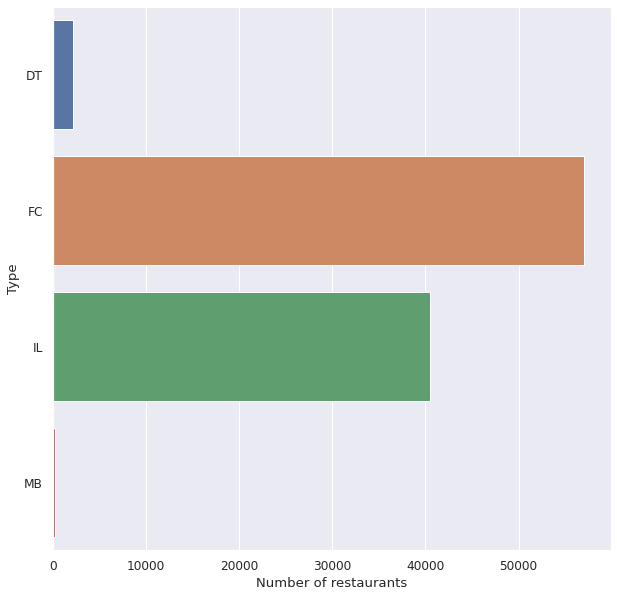

In [ ]:
tr = test_set.loc[:,['Type','P1']].groupby(['Type']).count().rename(columns={"P1": "Number of restaurants"})
print(tr)

fig_dims = (10, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x = "Number of restaurants", y = "Type",  ax=ax, data=tr.reset_index())

From this output we can see that in Turkey the most popular type of restaurant is the Food Court followed by the In-Line. On the other side there is a very small number of Drive Through and Mobile Restaurants.


Going on with our data exploration, we now visualize for each city of the test_set the number of restaurants per type.


In [ ]:
df = test_set.loc[:,['City','Type','City Group']].groupby(['City','Type']).count().rename(columns={"City Group": "Number of restaurants"})
df

Number of restaurants
City           Type                       
Adana          DT                       47
               FC                     1411
               IL                     1052
               MB                        4
Afyonkarahisar DT                        5
...                                    ...
İzmir          MB                       11
Şanlıurfa      DT                        9
               FC                      352
               IL                      247
               MB                        1

[212 rows x 1 columns]

We have decided to delete all the values of Istanbul because otherwise it would have outscaled the plot

In [ ]:
df = df.drop(index='İstanbul')

In [ ]:
# with idf we are going to represent the dataframe with Istanbul ...
idf = test_set[test_set.City == 'İstanbul'].loc[:,['City','Type','City Group']].groupby(['City','Type']).count().rename(columns={"City Group": "Number of restaurants"})
idf2 = idf.reset_index()

In [ ]:
# ... while df2 will be the dataframe without Istanbul with resetted indexes
df2 = df.reset_index()
df2

,City,Type,Number of restaurants
0,Adana,DT,47
1,Adana,FC,1411
2,Adana,IL,1052
3,Adana,MB,4
4,Afyonkarahisar,DT,5
...,...,...,...
203,İzmir,MB,11
204,Şanlıurfa,DT,9
205,Şanlıurfa,FC,352
206,Şanlıurfa,IL,247


Here there is the plot of all the cities excluding Istanbul:

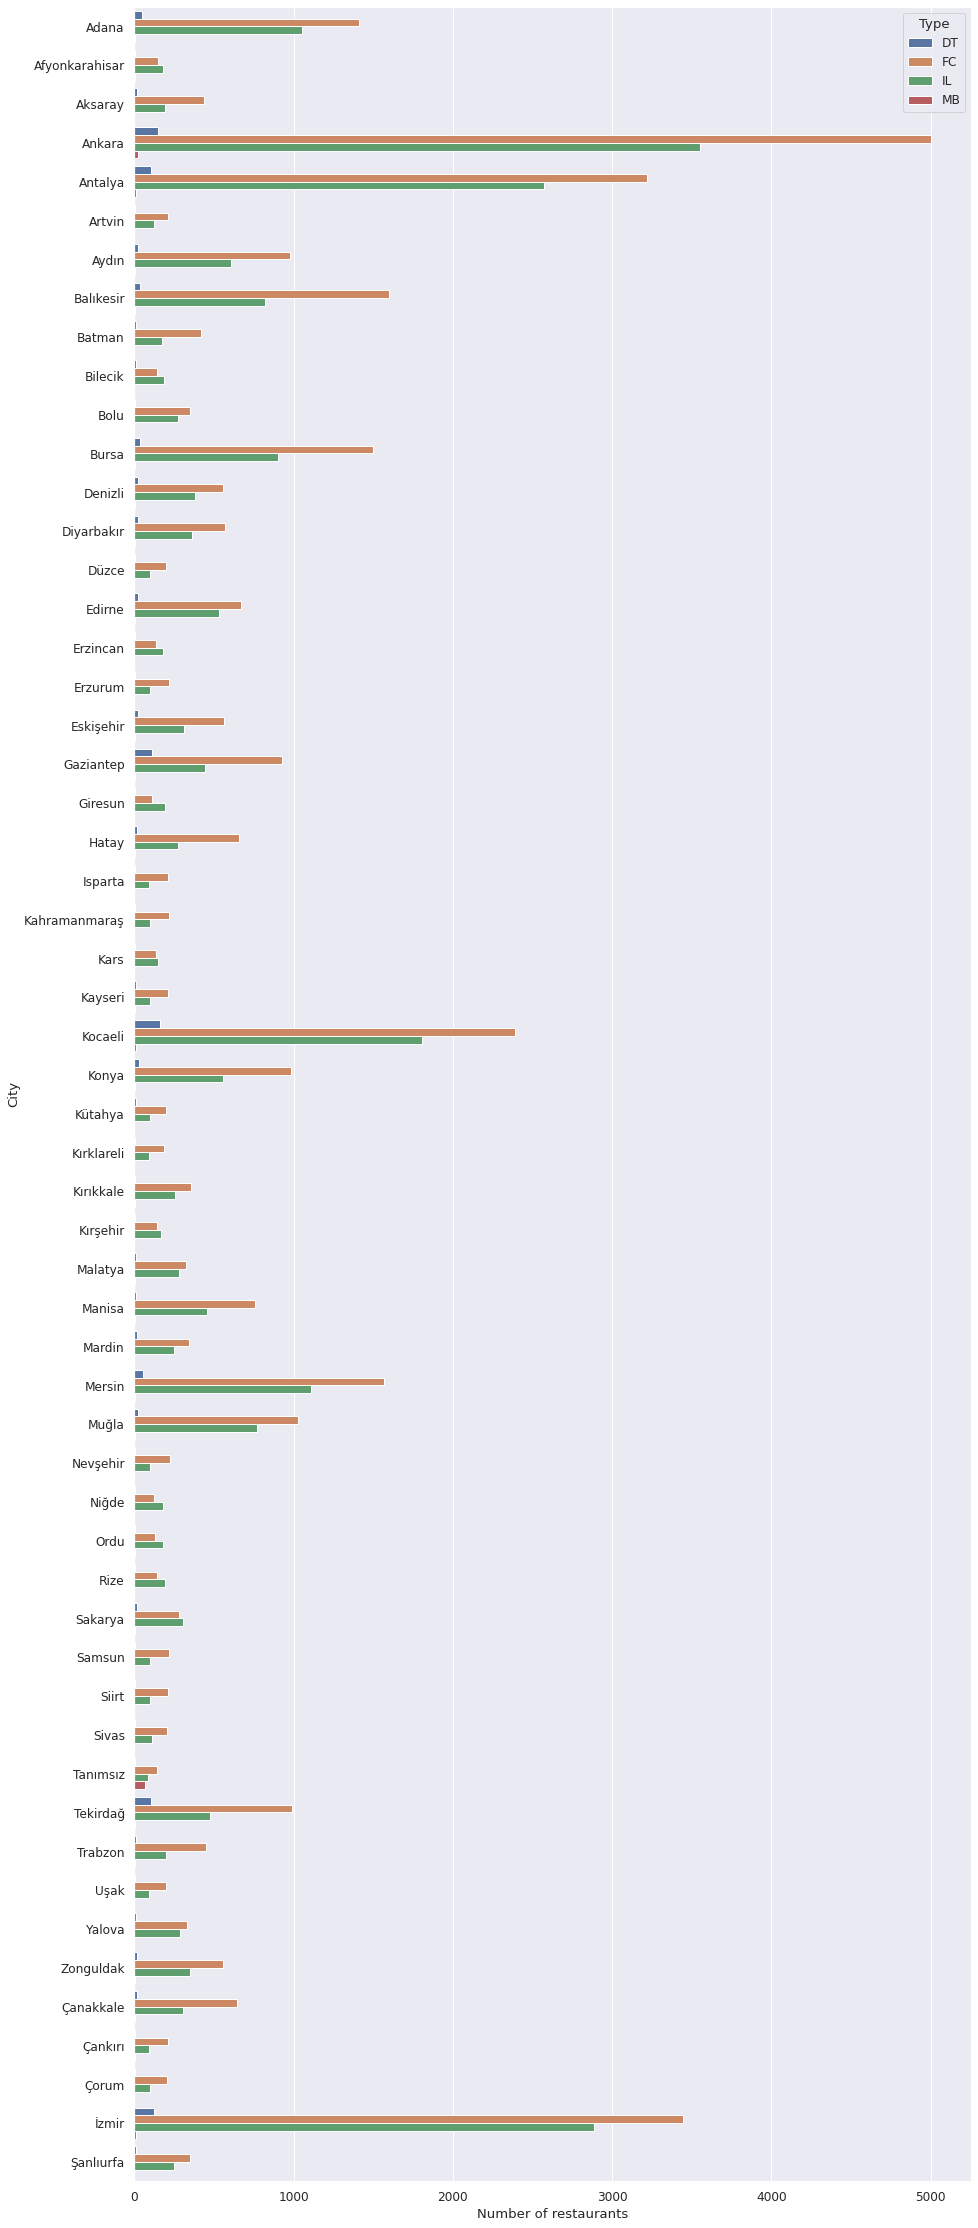

In [ ]:
fig_dims = (15, 40)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x = "Number of restaurants", y = "City",hue='Type',  ax=ax, data=df2)

Here there is the plot regarding just Istanbul:

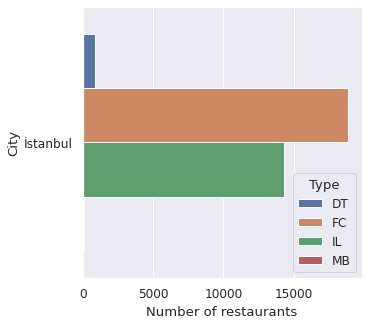

In [ ]:
fig_dims = (5, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x = "Number of restaurants", y = "City",hue='Type',  ax=ax, data=idf2)

As we can see, the number of restaurants in Istanbul are the highest between all the Turkish cities - this can be noted by giving a quick look at the different scale on the x-axis.
Another thing we can see is that in almost every city, the Food Court and In-Line restaurants are the most popular restaurant types

We are going now to do the same thing as before but grouping by the City type:

   City Group Type  Number of restaurants
0  Big Cities   DT                   1122
1  Big Cities   FC                  27319
2  Big Cities   IL                  20717
3  Big Cities   MB                    114
4       Other   DT                   1122
5       Other   FC                  29700
6       Other   IL                  19730
7       Other   MB                    176


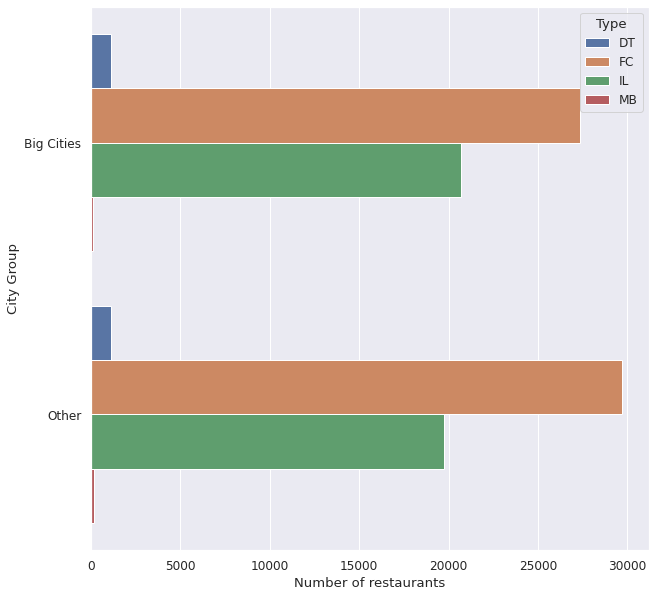

In [ ]:
cg = test_set.loc[:,['City Group','Type','P1']].groupby(['City Group','Type']).count().rename(columns={"P1": "Number of restaurants"})
cg_n = cg.reset_index()

print(cg_n)

fig_dims = (10, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x = "Number of restaurants", y = "City Group", hue='Type',  ax=ax, data=cg_n)

We can see that in both cases the distribution of the restaurants is similar.

#### Let us give a look at the role of the revenue in the train_set

In [ ]:
# relation btw Revenue and City(number of Counts)
city_revenue = train_set[['City','revenue']].groupby('City', as_index=False).mean()
c_counts=pd.DataFrame(train_set.groupby('City', as_index=False).count())

city_revenue_count = pd.concat([city_revenue,c_counts['Type']], axis=1).sort_values('revenue',ascending=False)
city_revenue_count = city_revenue_count.rename(columns = {"Type":"Count"}) 
city_revenue_count[:3]

,City,revenue,Count
31,İstanbul,5577811.96,50
12,Elazığ,5525735.00,1
11,Edirne,5444227.00,1


From this analysis we can easily see which are **the best cities to open a restaurant in**.

This is actually based on a mean value of the revenues on the train set, but we believe it is quite a valid result.

We can also see that even if in Istanbul the competition is quite high (50 competitor restaurants), the revenue is still the highest among all other cities.

We will see now which will be the type of restaurant to open based on the revenues we have in the train_set.

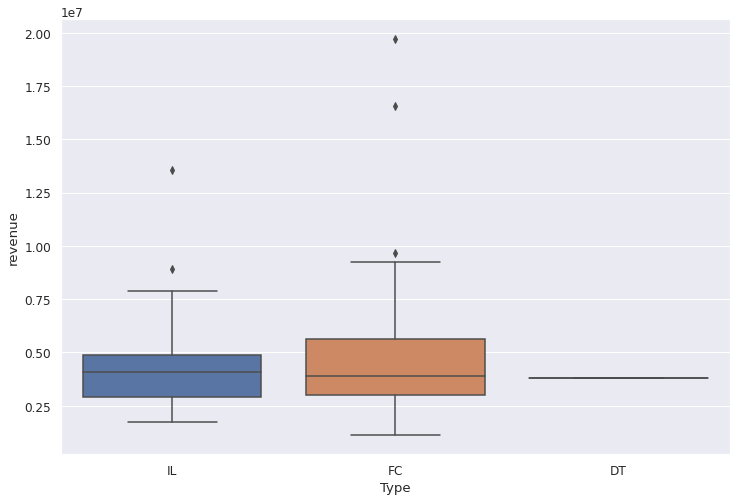

In [ ]:
f, ax = plt.subplots(figsize=(12,8))
sns.boxplot(y=train_set['revenue'], x=train_set['Type'])
plt.xticks()
plt.show()

Given the three different types of restaurants that we find in our train_set, it can be stated that the food court restaurant is the one with higher revenues, even if the FC's median is a little bit lower than the one from the InLine restaurants.

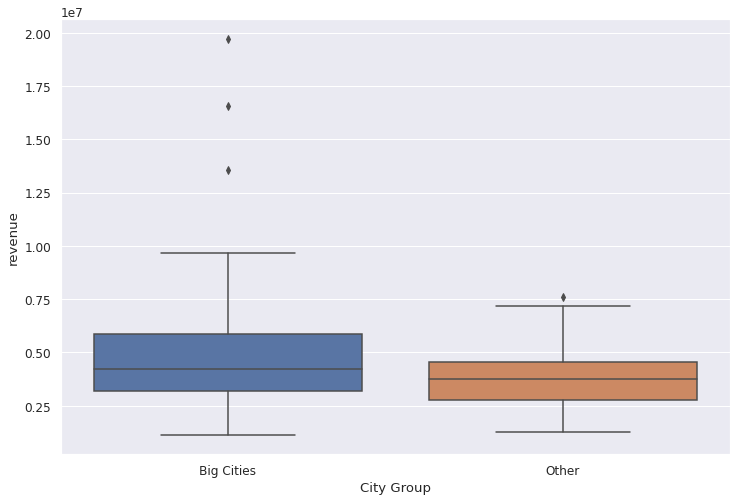

In [ ]:
f, ax = plt.subplots(figsize=(12,8))
sns.boxplot(y=train_set['revenue'], x=train_set['City Group'])
plt.xticks()
plt.show()

Also, we can see that the restaurants which are opened in Big Cities are (usually) going to have higher revenues than the ones in other types of cities.

Let us now see how and if the parameters P1 to P37 are correlated to the provided revenue and how they are correlated between themselves. For the former we are going to use one scatter plot for each parameter P, while for the latter we will use a heatmap.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


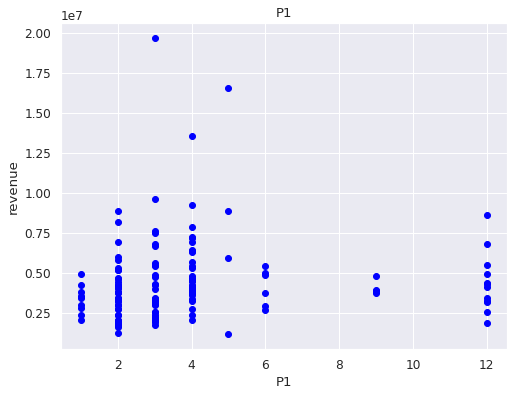

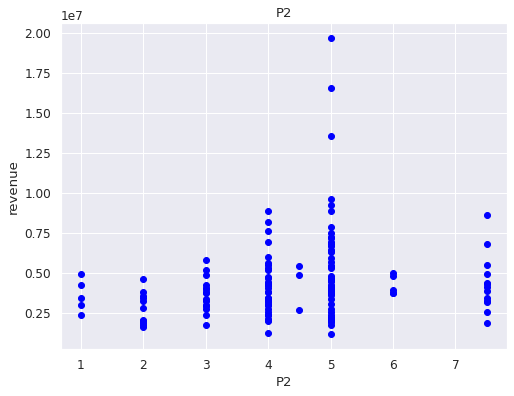

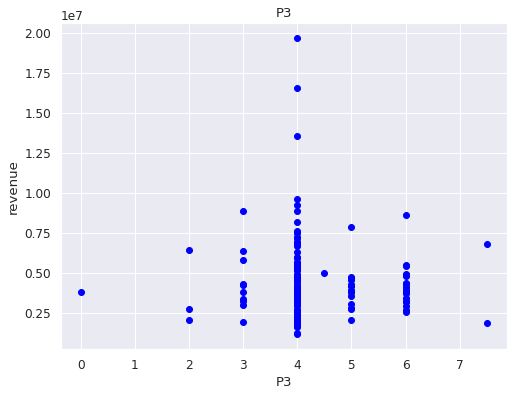

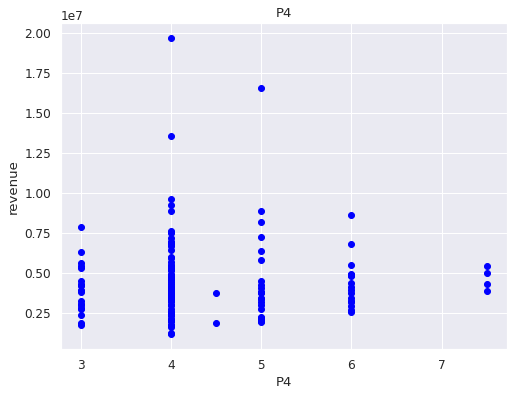

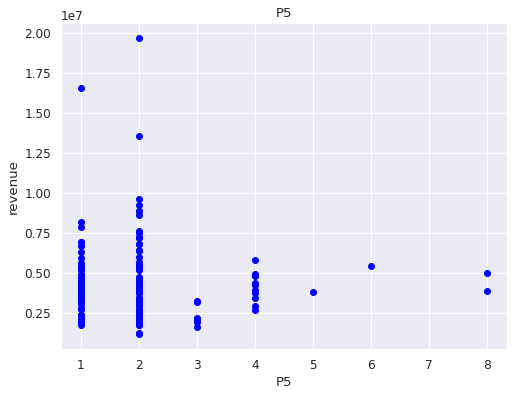

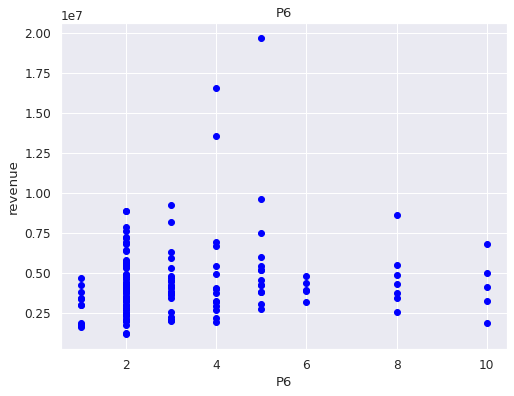

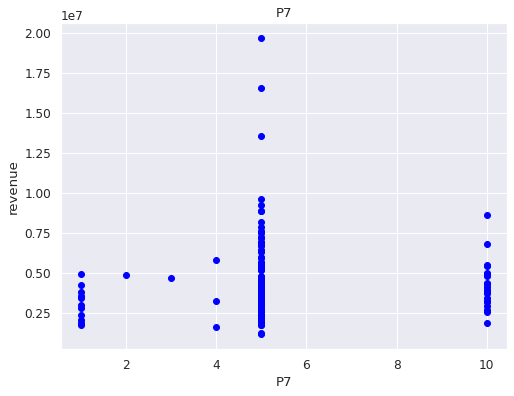

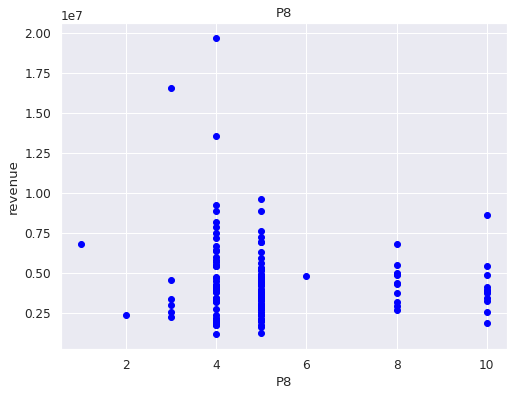

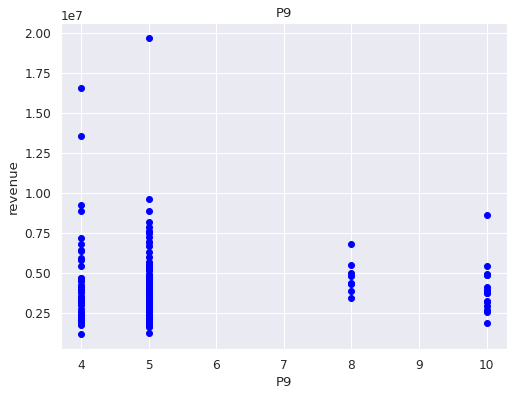

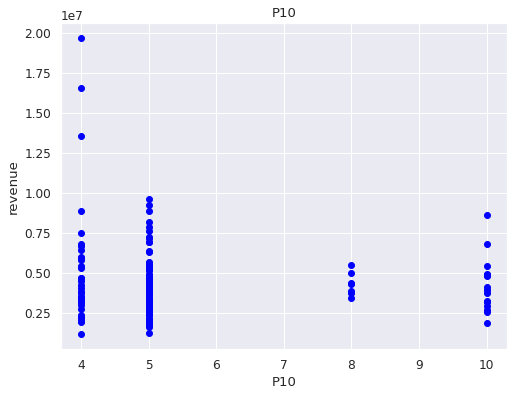

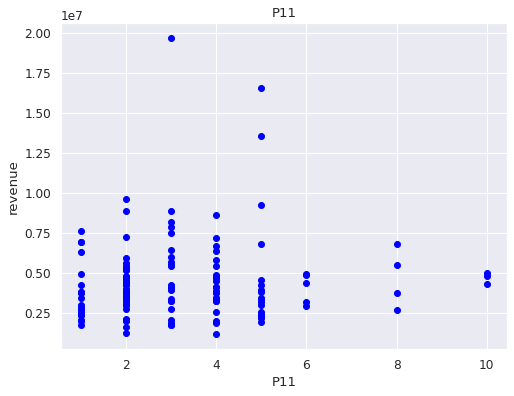

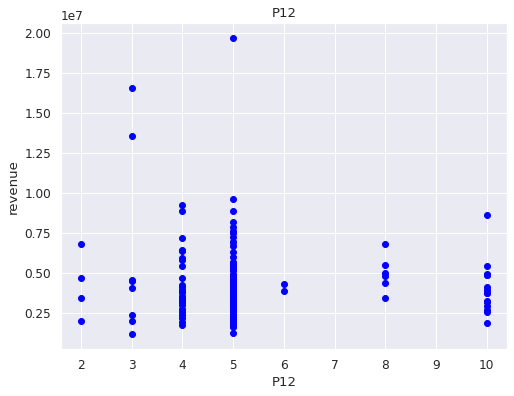

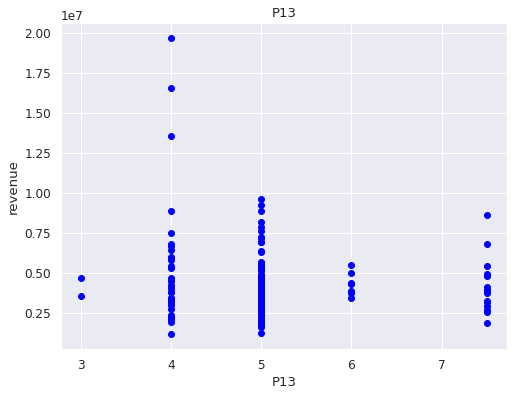

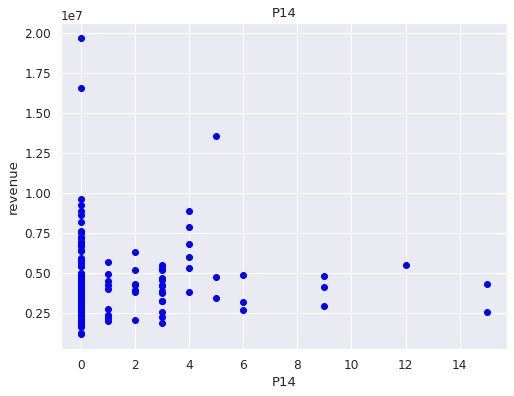

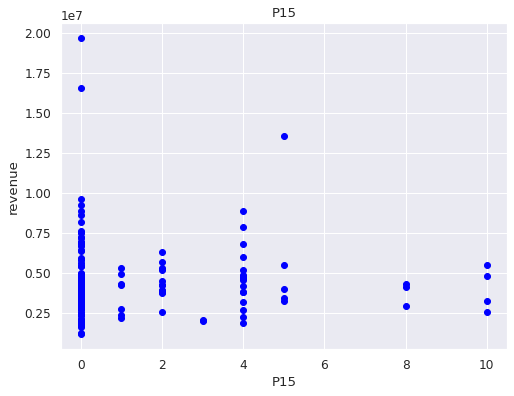

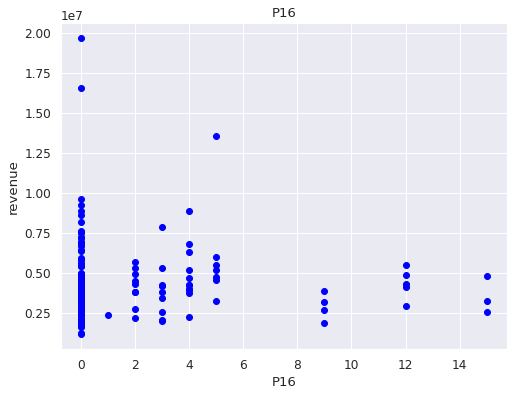

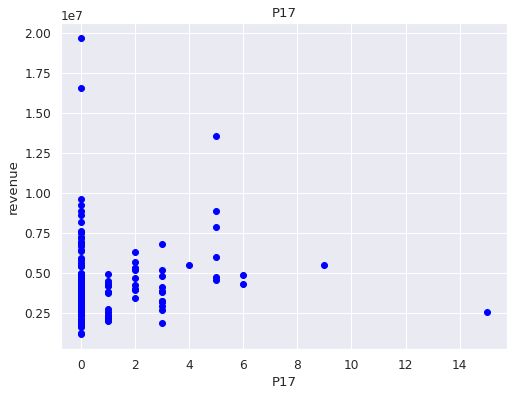

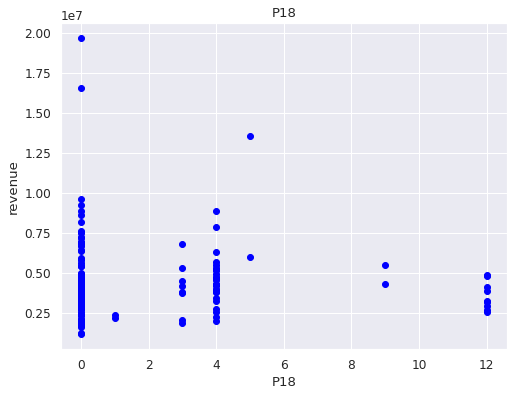

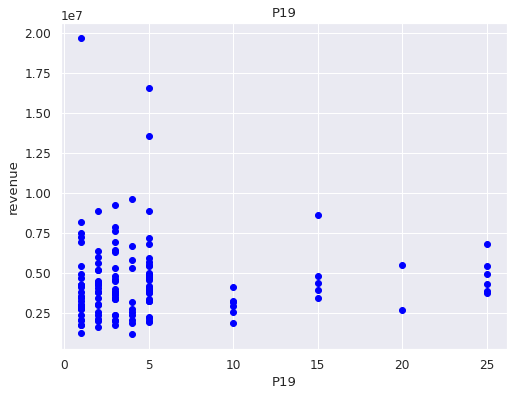

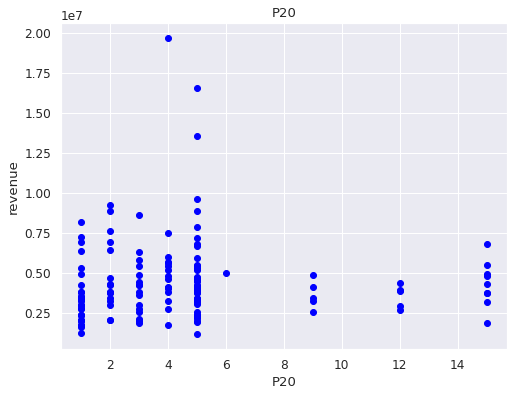

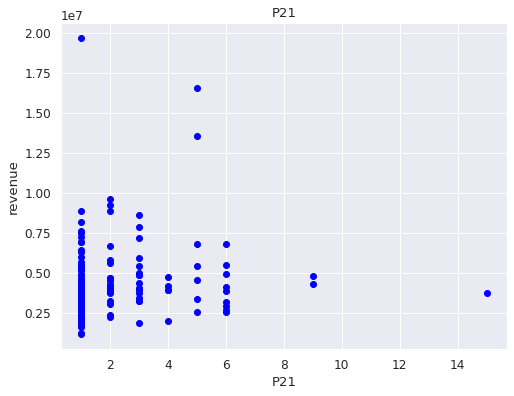

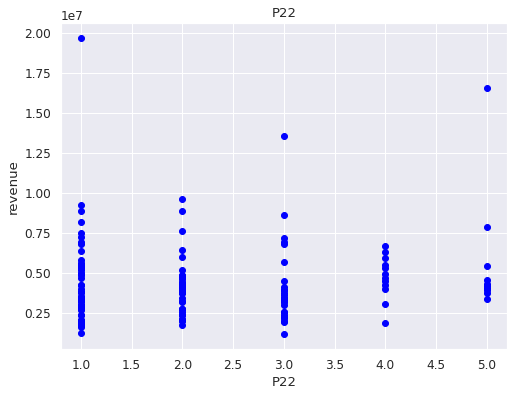

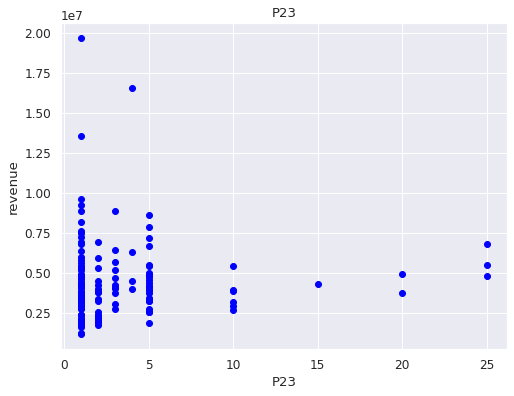

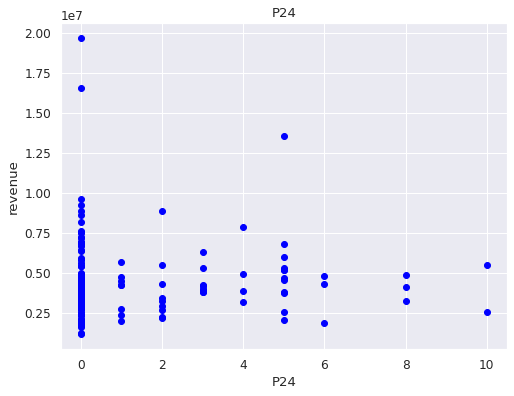

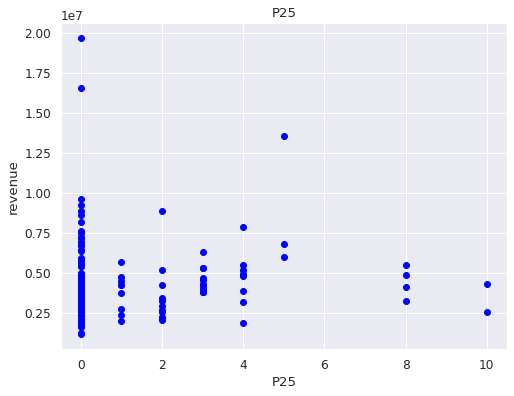

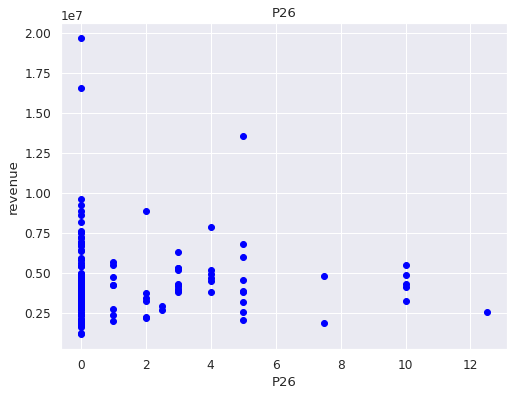

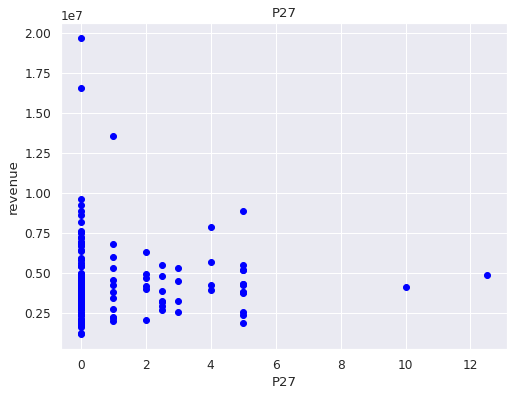

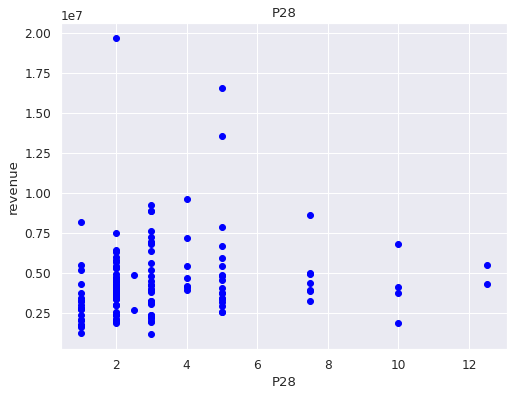

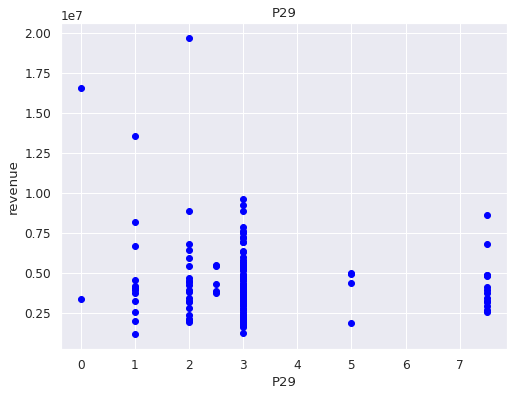

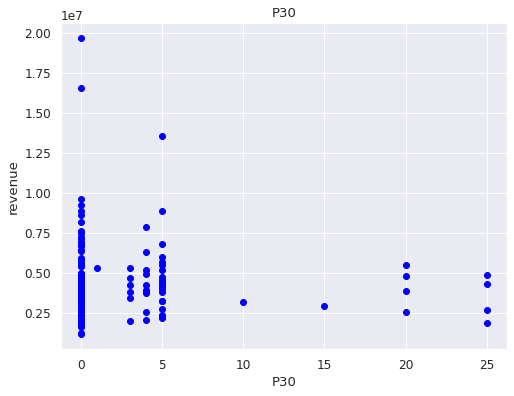

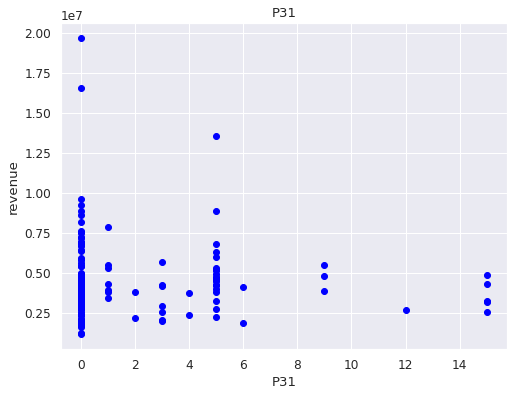

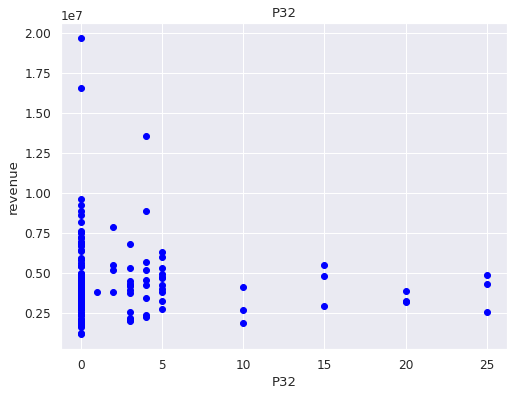

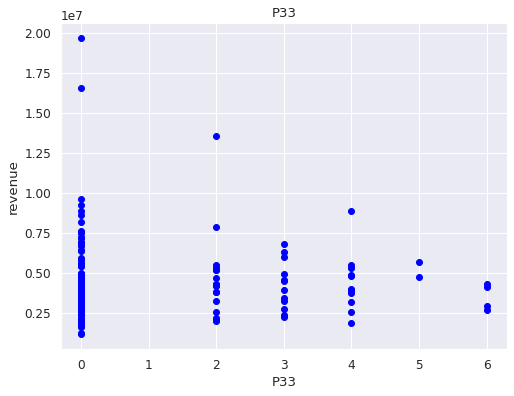

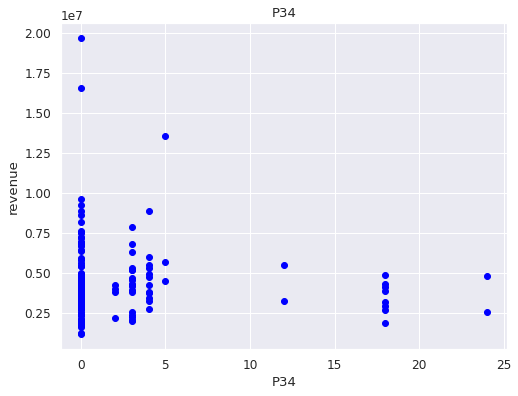

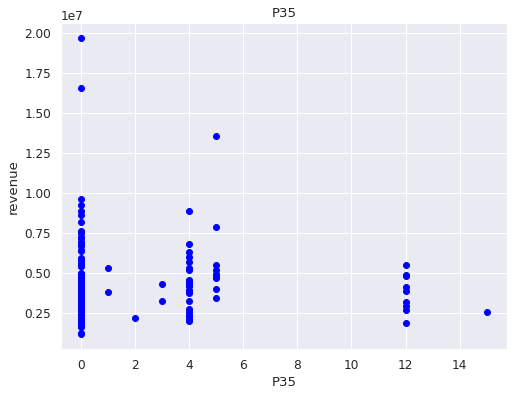

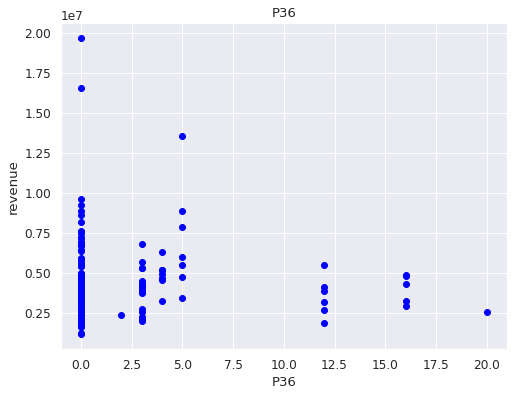

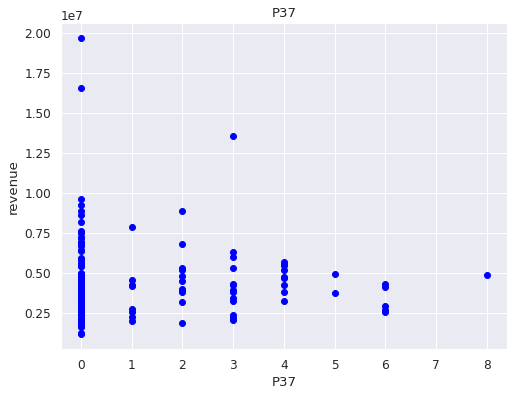

In [ ]:
for k in range (1,38):    
    X = train_set[['P'+str(k)]] # selecting every feature one by one
    Y = train_set[['revenue']]
    
    plt.figure(figsize=(8, 6))
    plt.scatter(X,Y,color='blue')
    plt.title('P'+str(k))
    ax = plt.axes()
    ax.set_xlabel('P'+str(k)) 
    ax.set_ylabel('revenue')
    plt.show()

### Correlation Matrix

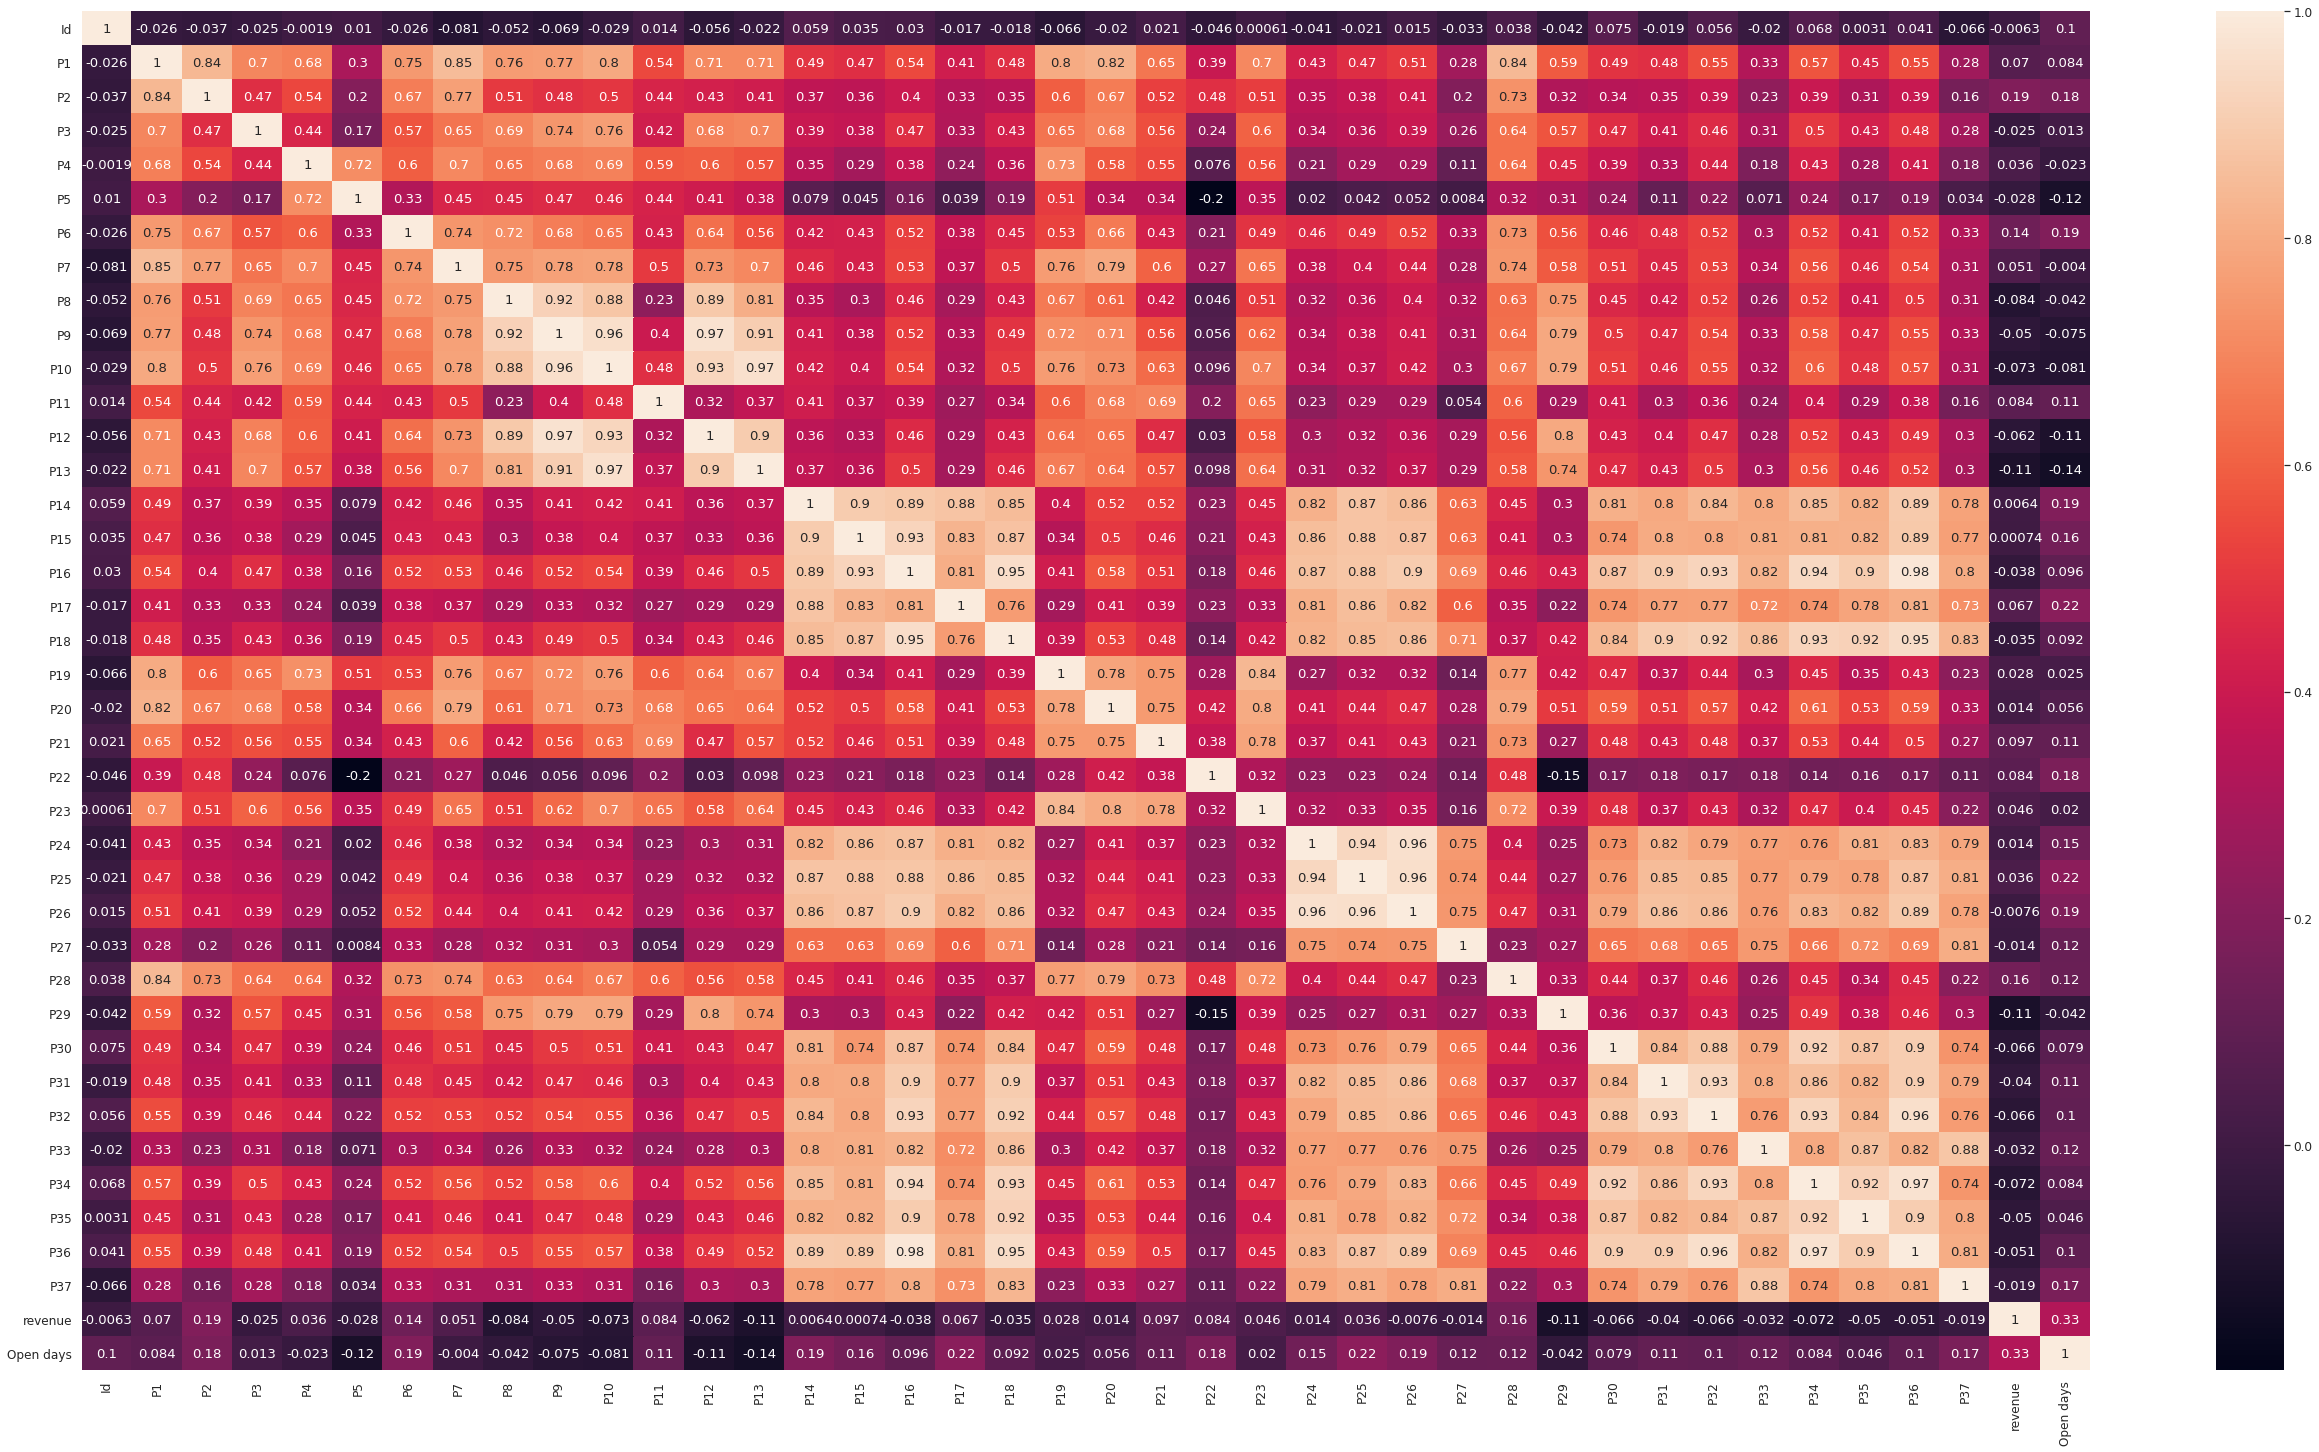

In [ ]:
plt.figure(figsize=(45,25))
sns.heatmap(train_set.corr(),annot=True)

As the heatmap and the scatter distribution clearly shows that there is no obvious releation between numerical variables independtly with the target.

We can also actually see how the P values are correlated between themselves and how they arecreating some kind of clusters of similar values. We believe that these clusters are due to the fact that these features come from specific types of data (demographic data, real estate data and commercial data).

## Splitting train set in train and validation

This is necessary in order to train our Linear Regression model and to have some kind of the data on which we are going to validate our computation, but first ...

In [ ]:
# Drop outlayers - if it is necessary to the analysis
train_set_ = train_set[train_set['revenue'] < 10000000]
train_set_.reset_index(drop=True).head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue,Open days
0,0,1999-07-17,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,1,2,2,2,4,5,4,1,3,3,1,1,1.0,4.0,2.0,3.0,5,3,4,5,5,4,3,4,5653753.0,5.803
1,1,2008-02-14,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,5,5,5,1,5,5.0,0,0,0,0,0,3,2,1,3,2,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,6923131.0,2.669
2,2,2013-03-09,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2055379.0,0.819
3,3,2012-02-02,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,10,8,10,10,8,10,7.5,6,4,9,3,12,20,12,6,1,10,2,2,2.5,2.5,2.5,7.5,25,12,10,6,18,12,12,6,2675511.0,1.220
4,4,2009-05-09,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,5,5,5,5,2,5,5.0,2,1,2,1,4,2,2,1,2,1,2,3,3.0,5.0,1.0,3.0,5,1,3,2,3,4,3,3,4316715.0,2.219


In [ ]:
tr=pd.Index(np.random.choice(range(137),100,replace=False))
tot=pd.Index(range(137))
valid=tot.difference(tr)
tr_set=train_set.loc[tr]
validation_set=train_set.loc[valid]
validation_set.shape , tr_set.shape

((37, 44), (100, 44))

# Linear Regression

We decided to apply linear regression on three different cases where in each one we are going to try to develop better results for the Mean Square Error (MSE).

The three different cases we considered are:
1. Applying linear regression considering all the 37 features with the same weight
2. Applying linear regression after having computed a Priciple Component Analysis – PCA
3. Applying linear regression using the forward approach

We are firstly going to show these three different results and afterwards we are going to analyse them.

### First case - "simple" linear regression

In [ ]:
features = ['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10','P11','P12','P13','P14','P15','P16','P17','P18','P19','P20','P21','P22','P23','P24','P25','P26','P27','P28','P29','P30','P31','P32','P33','P34','P35','P36','P37']

In [ ]:
# Using the Linear regression to fit the x of the train set 
reg1=LinearRegression().fit(tr_set[features],tr_set['revenue'])
print(reg1.intercept_)
print(reg1.coef_)

8845847.282262161
[   74653.67898656   640414.28377742  -947708.45169097  -114585.65909605
  -364863.35487955   623911.949614    -202309.37212244 -1173128.67728872
  2186308.86281795  -772278.42234252  -326544.41942236  -214189.902284
  -493341.26206098 -1619590.86541272   871893.51221874 -1397489.38026651
   482753.36967301    78181.09606463     3686.38330088  -340494.77663634
  1560601.86861383  -837386.52363323   -87532.82748098  1959711.36101432
  -153788.09147045 -2389141.44732825  -500756.12028896   509934.57595708
  -205330.37069119  -341624.87472111  -237708.07074327  -307531.6634554
   150063.28351953    69027.82617227  -394364.44639137  2732911.44961961
   520307.48112628]


In [ ]:
# Calculating the revenue and comparing it with the real values to computing is the mean squared error
predictions = reg1.predict(validation_set[features])
reals = np.array(validation_set['revenue'])
first_case_mse = mean_squared_error(reals, predictions)
first_case_mse

34362351231424.75

### Second case - linear regression after PCA

In [ ]:
# We proceed for a principal component analysis before fitting a linear model

# Excluding all the variables but the Ps and take a subset of them
subtr = train_set.loc[:, features].values
subtr = StandardScaler().fit_transform(subtr)

# and we normalize the variables
feat_cols = ['P'+str(i+1) for i in range(subtr.shape[1])]
norm_train=pd.DataFrame(subtr,columns=feat_cols)
norm_train.head()

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37
0,-0.005034,0.391716,-0.308701,-0.367578,-0.006056,-0.638471,-0.185001,-0.622801,-0.243564,-0.265672,-0.138027,-0.154696,-0.077747,-0.152985,0.256553,0.016718,0.476215,0.625941,0.016993,-0.148179,-0.621025,0.630997,-0.093190,-0.162157,-0.099596,-0.180906,1.385793,-0.531493,-0.080631,0.411513,0.302463,0.282950,2.281657,0.487922,0.575634,0.189821,1.615951
1,-0.005034,0.391716,-0.308701,-0.367578,-0.835796,-0.638471,-0.185001,-0.082777,-0.243564,-0.265672,-1.188569,-0.154696,-0.077747,-0.520686,-0.580299,-0.555858,-0.512292,-0.590426,-0.341174,-0.689527,-0.621025,0.630997,-0.313312,-0.597757,-0.570100,-0.565156,-0.556444,-0.096779,-0.080631,-0.494874,-0.554863,-0.484658,-0.672851,-0.483667,-0.592690,-0.532553,-0.625925
2,-0.694749,-0.270816,-2.253162,0.619837,-0.006056,-0.168199,-0.185001,-0.082777,-0.243564,-0.265672,-0.663298,-0.154696,-0.077747,-0.520686,-0.580299,-0.555858,-0.512292,-0.590426,-0.699342,-0.960201,-0.621025,-1.000071,-0.533434,-0.597757,-0.570100,-0.565156,-0.556444,-0.966207,-0.080631,-0.494874,-0.554863,-0.484658,-0.672851,-0.483667,-0.592690,-0.532553,-0.625925
3,0.684680,0.060450,1.635760,1.607252,1.653422,0.302072,1.999921,1.537293,2.491539,2.450529,2.488326,2.429860,2.343005,1.685519,1.093406,2.020732,0.970468,3.058675,2.703252,2.017212,1.823814,-1.000071,1.447663,0.273442,0.370909,0.395469,0.657454,-0.314136,2.606351,4.037064,2.874441,1.434362,2.872558,3.014054,2.912282,2.356945,2.736889
4,-0.349892,-0.270816,-1.280931,-0.367578,-0.006056,-0.638471,-0.185001,-0.082777,-0.243564,-0.265672,-0.663298,-0.154696,-0.077747,0.214716,-0.161873,0.016718,-0.018038,0.625941,-0.520258,-0.689527,-0.621025,-0.184537,-0.533434,0.273442,0.841413,0.587594,1.871352,-0.966207,-0.080631,0.411513,-0.269088,0.091048,0.508952,0.099286,0.575634,0.189821,1.055482


In [ ]:
# After evaluating the number of components we get the new Data Frame with only the "PCA features"

pca_cities = PCA(n_components=5)
principalComponents = pca_cities.fit_transform(norm_train)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2','pc3','pc4','pc5'])

principalDf['Id']=train_set['Id']
principalDf.head()

,pc1,pc2,pc3,pc4,pc5,Id
0,0.797436,-2.125021,-0.065702,-0.016322,-0.440947,0
1,-2.528972,0.572364,0.100643,-1.352795,-0.041713,1
2,-3.066027,0.187874,-1.152090,0.664442,1.174567,2
3,10.754111,0.560106,-2.876801,3.290394,-2.476937,3
4,-0.066251,-2.511757,-1.098275,-0.099905,0.453485,4


In [ ]:
# Doing so we gain a total 85% of kept variance
print(pca_cities.explained_variance_ratio_)
print("Variance: ",sum(pca_cities.explained_variance_ratio_))

[0.55141273 0.17424829 0.06374001 0.0395284  0.02816485]
Variance:  0.8570942825363347


In [ ]:
# Merging the other variables of the first dataframe (excluding the Ps) with the Principal components
Train_pca=pd.DataFrame(data=train_set,columns=['Id', 'Open Date', 'City', 'City Group', 'Type','revenue'])
result=pd.merge(Train_pca,principalDf)
result.head()

,Id,Open Date,City,City Group,Type,revenue,pc1,pc2,pc3,pc4,pc5
0,0,1999-07-17,İstanbul,Big Cities,IL,5653753.0,0.797436,-2.125021,-0.065702,-0.016322,-0.440947
1,1,2008-02-14,Ankara,Big Cities,FC,6923131.0,-2.528972,0.572364,0.100643,-1.352795,-0.041713
2,2,2013-03-09,Diyarbakır,Other,IL,2055379.0,-3.066027,0.187874,-1.152090,0.664442,1.174567
3,3,2012-02-02,Tokat,Other,IL,2675511.0,10.754111,0.560106,-2.876801,3.290394,-2.476937
4,4,2009-05-09,Gaziantep,Other,IL,4316715.0,-0.066251,-2.511757,-1.098275,-0.099905,0.453485


In [ ]:
# in order to work with the PCA parameters we define two different dataframes coming from the train_set
tr_set_=result.loc[tr]
validation_set_=result.loc[valid]
print(validation_set_.shape, tr_set_.shape)

(37, 11) (100, 11)


In [ ]:
# load the external factor pattern that we will apply on the test set
fact=np.loadtxt('../factor pattern.txt')
print(fact)

[[ 0.79069 -0.45607 -0.17482 -0.20559 -0.11241]
 [ 0.59845 -0.35816 -0.39997 -0.27184 -0.34585]
 [ 0.6756  -0.38213  0.04105 -0.23244  0.28307]
 [ 0.60706 -0.50471 -0.00107  0.33943 -0.34135]
 [ 0.33059 -0.43532  0.18531  0.63566 -0.33068]
 [ 0.70595 -0.32068 -0.00157 -0.224   -0.38934]
 [ 0.76516 -0.45921 -0.05372 -0.08267 -0.17362]
 [ 0.70587 -0.47924  0.37064 -0.19594 -0.12058]
 [ 0.76614 -0.49423  0.33958 -0.07927  0.06971]
 [ 0.78143 -0.51359  0.27226 -0.03769  0.14625]
 [ 0.53376 -0.32367 -0.38679  0.4512   0.06492]
 [ 0.70109 -0.4899   0.40597 -0.14394  0.09622]
 [ 0.71403 -0.4651   0.3185  -0.08869  0.23788]
 [ 0.83519  0.38996 -0.11901  0.07966  0.03593]
 [ 0.81373  0.42504 -0.10165  0.02872  0.02766]
 [ 0.9071   0.35429  0.02727  0.0516   0.00797]
 [ 0.74483  0.44913 -0.10241 -0.01039 -0.03743]
 [ 0.87161  0.38456  0.08387  0.10037  0.02413]
 [ 0.6877  -0.53771 -0.19784  0.16745  0.09909]
 [ 0.78932 -0.38013 -0.2587   0.00552  0.13141]
 [ 0.68041 -0.30717 -0.38963  0.22156  0

Note that this factor pattern has been given in output from the python program at the following link:

http://y-okamoto-psy1949.la.coocan.jp/Python/sampleprgs/pca/en/

In [ ]:
# Take a subset of the test set and scale it

subtes = test_set.loc[:, features].values
subtes = StandardScaler().fit_transform(subtes)
feat_cols = ['P'+str(i+1) for i in range(subtes.shape[1])]
norm_test=pd.DataFrame(subtes,columns=feat_cols)
names=['pc1', 'pc2','pc3','pc4','pc5']

# Apply the factor pattern to get the "principal components"

testpca=norm_test @ fact
test=pd.DataFrame(data=testpca)
test.rename(columns={0:'pc1',1:'pc2',2:'pc3',3:'pc4',4:'pc5'},inplace=True)
test['Id']=test_set['Id']

test.head()


,pc1,pc2,pc3,pc4,pc5,Id
0,-11.537515,-0.344118,-0.745444,0.943145,0.579734,0
1,-12.787080,-0.423557,-0.212318,0.408240,0.309766,1
2,-8.991299,-2.510988,-2.238393,-0.011584,1.123247,2
3,-8.753705,-0.120123,0.136132,0.495352,0.044277,3
4,-11.952002,-0.812042,-0.272886,-0.086117,0.120925,4


In [ ]:
# Merging with the excluded variables

Test_pca=pd.DataFrame(data=test_set,columns=['Id', 'Open Date', 'City', 'City Group', 'Type','revenue'])
test_fin=pd.merge(Test_pca,test)
test_fin.head()

,Id,Open Date,City,City Group,Type,revenue,pc1,pc2,pc3,pc4,pc5
0,0,2011-01-22,Niğde,Other,FC,NaN,-11.537515,-0.344118,-0.745444,0.943145,0.579734
1,1,2011-03-18,Konya,Other,IL,NaN,-12.787080,-0.423557,-0.212318,0.408240,0.309766
2,2,2013-10-30,Ankara,Big Cities,FC,NaN,-8.991299,-2.510988,-2.238393,-0.011584,1.123247
3,3,2013-05-06,Kocaeli,Other,IL,NaN,-8.753705,-0.120123,0.136132,0.495352,0.044277
4,4,2013-07-31,Afyonkarahisar,Other,FC,NaN,-11.952002,-0.812042,-0.272886,-0.086117,0.120925


In [ ]:
# Train the linear model on the updated train set after having done the slicing and the PCA

regtrain=LinearRegression().fit(tr_set_[['pc1','pc2','pc3','pc4','pc5']],tr_set_['revenue'])
print(regtrain.intercept_,regtrain.coef_)

4708862.947800259 [ -3161.70685479  44146.27175305 511737.63480126 -49967.19433526
 537390.53065627]


In [ ]:
# Finally, get the MSE from the validation subset

predizioni = regtrain.predict(validation_set_[['pc1','pc2','pc3','pc4','pc5']])
reali = np.array(validation_set_['revenue'])

second_case_mse = mean_squared_error(reali, predizioni)
second_case_mse

3149281012471.5664

### Third case - the forward approach


Forward selection typically begins with only an intercept. One tests the various variables that may be relevant, and the ‘best’ variable—where “best” is determined by some pre-determined criteria—is added to the model.

As the model continues to improve (per that same criteria) we continue the process, adding in one variable at a time and testing at each step. Once the model no longer improves with adding more variables, the process stops.

Bibliographic reference: https://www.statisticshowto.com/forward-selection/

In [ ]:
"""
Here we are going to find the parameters that improve the R2 score the most.
Obviusly, we have firstly printed all the values and we have noticed that the first 11 results were the most significant one.
"""

# creating the list of parameters we are going to consider
list_P = [] 

for k in range (1,12):
  diz = {}

  # cycling on all the 37 parameters
  for k in range (1,38):
      regr = LinearRegression()
      X = train_set[['P'+str(k)] + list_P ] 
      Y = train_set[['revenue']]
      regr.fit(X , Y )
      Y_pred = regr.predict(X)

      # saving in the dictionary all the values of r2
      diz[k] = r2_score(Y, Y_pred)

      # saving the key of the highest r2 value
      max_key = max(diz, key=diz.get)

  # appending the parameters which has the highest r2 value
  list_P.append('P'+str(max_key))

# Finally, we print the list of parameters we are going to consider and the corresponding r2_score value
print('r2: \n',r2_score(Y, Y_pred))
print(list_P)

r2: 
 0.22195436204165464
['P2', 'P8', 'P6', 'P34', 'P17', 'P9', 'P20', 'P28', 'P26', 'P13', 'P27']


In [ ]:
"""
We are now going to compute the Linear Regression on the parameters we found to be relevant and computing the MSE.
"""

regr = LinearRegression()
X = tr_set[['P2', 'P8', 'P6', 'P34', 'P17', 'P9', 'P20', 'P28', 'P26', 'P13', 'P27']] 
Y = tr_set[['revenue']]
regr.fit(X , Y)

X_val = validation_set[['P2', 'P8', 'P6', 'P34', 'P17', 'P9', 'P20', 'P28', 'P26', 'P13', 'P27']] 
Y_val = validation_set[['revenue']]

pred = regr.predict(X_val)

third_case_mse = mean_squared_error(Y_val,pred)
third_case_mse

2972737607727.283

In [ ]:
"""
Finally, let's add two columns to the dataframe. The "Our prediction" column will represent the values found through the linear regression,
while the "Error" column will show the error between the real value and the one we predicted.
"""

validation_set["Our prediction"] = pred
validation_set["Error"] = (validation_set["revenue"] / validation_set["Our prediction"])

validation_set[["Id","Open Date","City","City Group","Type","revenue","Our prediction","Error"]].head(15)

,Id,Open Date,City,City Group,Type,revenue,Our prediction,Error
2,2,2013-03-09,Diyarbakır,Other,IL,2055379.0,4.106619e+06,0.500504
4,4,2009-05-09,Gaziantep,Other,IL,4316715.0,2.733183e+06,1.579373
10,10,2013-08-09,Kocaeli,Other,FC,3745135.0,5.450134e+06,0.687164
11,11,2012-05-22,İstanbul,Big Cities,IL,5161370.0,4.292272e+06,1.202480
15,15,2012-02-07,İstanbul,Big Cities,IL,3218918.0,2.575818e+06,1.249668
18,18,2012-04-21,İzmir,Big Cities,IL,5337526.0,2.961917e+06,1.802051
27,27,1999-10-09,Bursa,Other,FC,5435276.0,4.629171e+06,1.174136
31,31,2012-12-31,İstanbul,Big Cities,IL,2058644.0,2.604500e+06,0.790418
35,35,1996-05-08,Adana,Other,IL,3903884.0,3.674745e+06,1.062355
38,38,2011-01-18,İstanbul,Big Cities,FC,5461700.0,6.881479e+06,0.793681


## Final considerations

Let us give a quick look at the three results:

In [ ]:
print("First method  – \"simple\" linear regression   : ", "{:.2e}".format(first_case_mse) )
print("Second method – linear regression after PCA  : ", "{:.2e}".format(second_case_mse) )
print("Third method  – the forward approach         : ", "{:.2e}".format(third_case_mse) )

First method  – "simple" linear regression   :  3.44e+13
Second method – linear regression after PCA  :  3.15e+12
Third method  – the forward approach         :  2.97e+12


Having computed the MSE value for the three different cases we have described, it is quite clear from the results we have obtained that the forward method gives us the lowest value for the Mean Square Error.

For this reason we are going to apply only the forward approach linear model on the entire test_set in order to compute our predictions and complete the original Kaggle task.

There is a **little note** to add to this...

Given the fact that everytime we restart the kernel we decided to randomly choose both the train and the validation set, we get obviously different results at each run that can also vary a lot. We decided to state that the third method is the best because having runned the kernel over and over we have seen that generally the forward approach gives better results than the other two. For this reason the final result on the test set will be predicted using the forward approach.

The best result for the forward approach that we have gained is 2.80e+12 which is by far better than the benchmark we have considered.

#### Applying it to the test_set

In [ ]:
# Computing the revenue on the test_set using Linear Regression with the forward method

X_final = test_set[['P2', 'P8', 'P6', 'P34', 'P17', 'P9', 'P20', 'P28', 'P26', 'P13', 'P27']] 

pred_final = regr.predict(X_final)

test_set["Prediction"] = pred_final
test_set[["Id","Open Date","City","City Group","Type","Prediction"]].head(15)

,Id,Open Date,City,City Group,Type,Prediction
0,0,2011-01-22,Niğde,Other,FC,6.086220e+06
1,1,2011-03-18,Konya,Other,IL,3.509619e+06
2,2,2013-10-30,Ankara,Big Cities,FC,2.919666e+06
3,3,2013-05-06,Kocaeli,Other,IL,4.843366e+06
4,4,2013-07-31,Afyonkarahisar,Other,FC,7.136435e+06
5,5,2007-11-29,Eskişehir,Other,FC,7.879859e+06
6,6,2008-11-05,Rize,Other,FC,3.313493e+06
7,7,2013-12-03,Ankara,Big Cities,IL,5.923402e+06
8,8,2006-05-30,İstanbul,Big Cities,IL,6.930149e+06
9,9,2012-01-20,İstanbul,Big Cities,IL,1.630415e+06


### Test_set analysis

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0, 0.5, 'P(revenue)'), Text(0.5, 0, 'predicted revenue')]

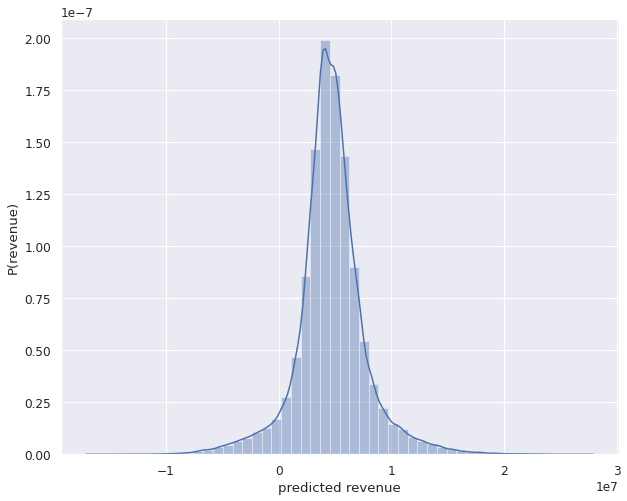

In [ ]:
# First of all let us see how the target column "revenue" is distributed

sns.set(palette="deep", font_scale=1.1, rc={"figure.figsize": [10, 8]})
sns.distplot(
    test_set['Prediction'], norm_hist=False, kde=True
).set(xlabel='predicted revenue', ylabel='P(revenue)')

In [ ]:
test_set['Prediction'].mean() , test_set['Prediction'].var()

(4644727.630014682, 9619591398850.928)

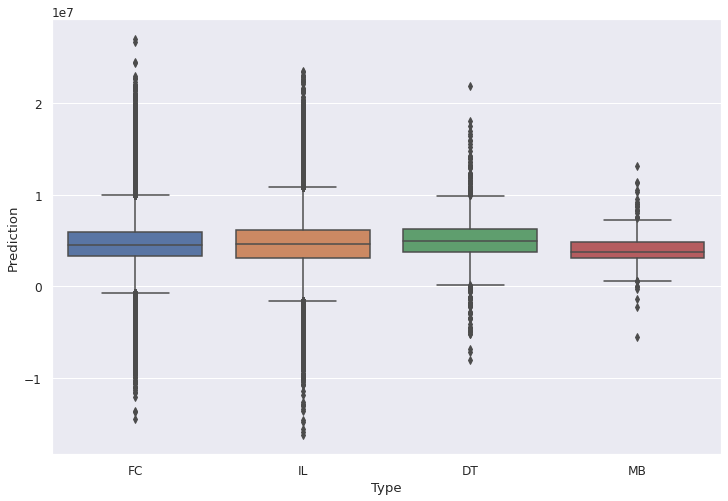

In [ ]:
f, ax = plt.subplots(figsize=(12,8))
sns.boxplot(y=test_set['Prediction'], x=test_set['Type'])
plt.xticks()
plt.show()

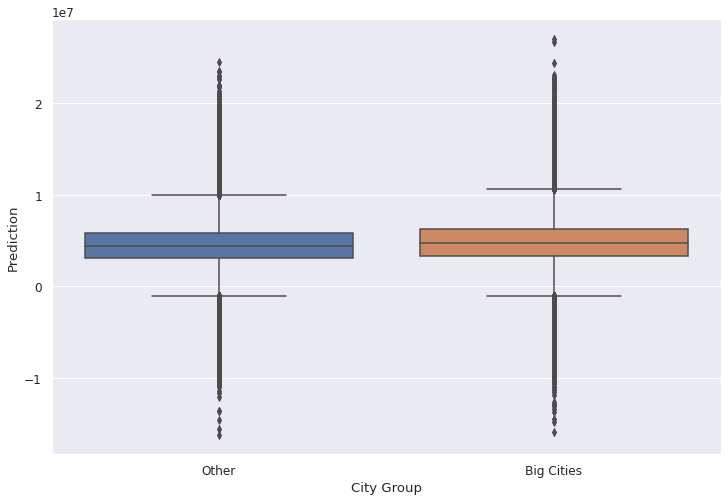

In [ ]:
f, ax = plt.subplots(figsize=(12,8))
sns.boxplot(y=test_set['Prediction'], x=test_set['City Group'])
plt.xticks()
plt.show()

The two shown boxplots do confirm the analysis we made on the initial test_set. In the first case we can see that FoodCourts and InLine restaurants are again the ones that perform better. Furthermore, Big Cities are generally related to a higher revenue than Other types of cities also with our predicted revenue. 

# Benchmark comparison

Comparing our results with the one of the following notebook:

https://www.kaggle.com/ayushikaushik/regression-analysis

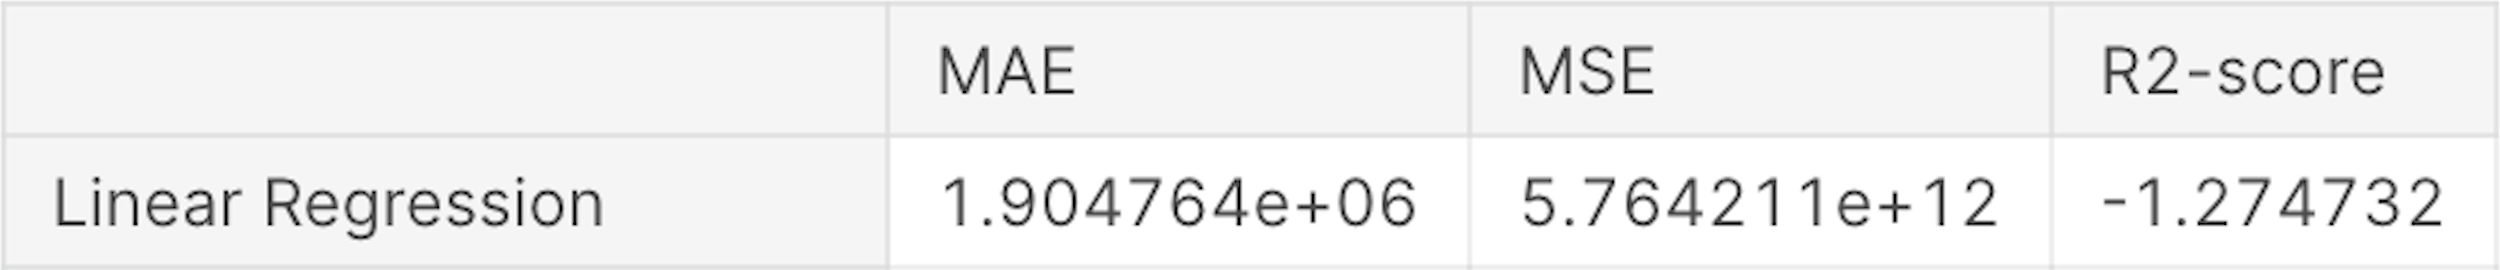

The most important thing to notice is that using the forward approach to implement our Linear Regression model the order of magnitude is the same as the benchmark we have selected. For sure we could have done better in some ways, but we believe it to be a notable achievement giving that this was our first Kaggle competition.

As 2.80e+12 is the best result we have obtained using the forward approach, we can see how the performance of our model is by far better than our bechmark. For this reason the group is (still) currently evaluating if effectively submit our results to the Kaggle competition and see how we rank there. We will let you know about this!

# Bibliography

- Kaggle competition: https://www.kaggle.com/c/restaurant-revenue-prediction
- External factor pattern: http://y-okamoto-psy1949.la.coocan.jp/Python/sampleprgs/pca/en/
- Kaggle benchmark: https://www.kaggle.com/ayushikaushik/regression-analysis